#### Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
# We can override the default matplotlib styles with those of Seaborn
sns.set()## Importing the relevant libraries

In [5]:
# Load the data from a .csv
raw_ratings_data = pd.read_csv(os.path.join(os.path.pardir,'data','raw','ratings.csv'))
raw_movies_data = pd.read_csv(os.path.join(os.path.pardir,'data','raw','movies.csv'))

In [6]:
raw_ratings_data.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
raw_movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


##### Since the movieId columns are the same we can merge these datasets on this column.

In [9]:
df = pd.merge(raw_ratings_data, raw_movies_data, on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


###### Brief description of the dataset

In [10]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
title        100836 non-null object
genres       100836 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


## Lets inspect the data
> Let’s now create a dataframe with the average rating for each movie and the number of ratings. We are going to use these ratings to calculate the correlation between the movies later. Correlation is a statistical measure that indicates the extent to which two or more variables fluctuate together. Movies that have a high correlation coefficient are the movies that are most similar to each other. In our case we shall use the Pearson correlation coefficient. This number will lie between -1 and 1. 1 indicates a positive linear correlation while -1 indicates a negative correlation. 0 indicates no linear correlation. Therefore movies with a zero correlation are not similar at all. In order to create this dataframe we use pandas groupby functionality. We group the dataset by the title column and compute its mean to obtain the average rating for each movie.

In [36]:
ratings_df = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings_df.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


>Next we would like to see the number of ratings for each movie. We do this by creating a `number_of_ratings` column. This is important so that we can see the relationship between the average rating of a movie and the number of ratings the movie got. It is very possible that a 5 star movie was rated by just one person. It is therefore statistically incorrect to classify that movie has a 5 star movie. We will therefore need to set a threshold for the minimum number of ratings as we build the recommender system.

In [37]:
ratings_df['number_of_ratings'] = df.groupby('title')['rating'].count()
ratings_df.head()

,rating,number_of_ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


##### Plot histogram

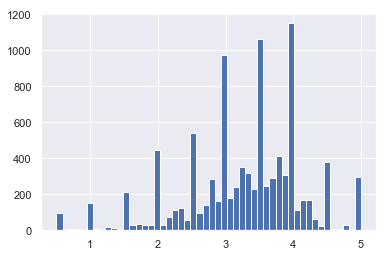

In [16]:
ratings_df['rating'].hist(bins=50);
# We can see that most of the movies are rated between 2.5 and 4

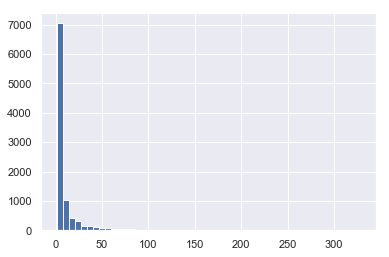

In [28]:
ratings_df['genres'] = df.groupby('title')['rating'].count()
ratings_df['genres'].hist(bins=50);


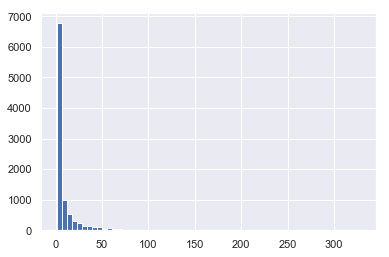

In [24]:
ratings_df['number_of_ratings'].hist(bins=60);
# it is clear that most movies have few ratings. Movies with most ratings are those that are most famous.

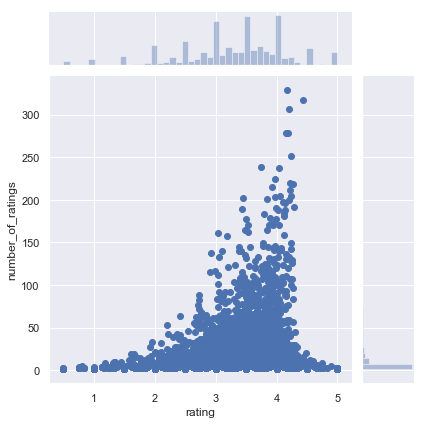

In [26]:
# Let’s now check the relationship between the rating of a movie and the number of ratings.
sns.jointplot(x='rating', y='number_of_ratings', data=ratings_df);


> From the diagram we can see that their is a positive relationship between the average rating of a movie and the number of ratings. The graph indicates that the more the ratings a movie gets the higher the average rating it gets. This is important to note especially when choosing the threshold for the number of ratings per movie.
***
> Let’s now move on swiftly and create a simple item based recommender system. In order to do this we need to convert our dataset into a matrix with the movie titles as the columns, the user_id as the index and the ratings as the values. By doing this we shall get a dataframe with the columns as the movie titles and the rows as the user ids. Each column represents all the ratings of a movie by all users. The rating appear as NAN where a user didn't rate a certain movie. We shall use this matrix to compute the correlation between the ratings of a single movie and the rest of the movies in the matrix. We use pandas pivot_table utility to create the movie matrix.

In [33]:
movie_matrix = df.pivot_table(index='userId', columns='title', values='rating')
movie_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


> Next let’s look at the most rated movies and choose two of them to work with in this simple recommender system. We use pandas sort_values utility and set ascending to false in order to arrange the movies from the most rated.

In [38]:
ratings_df.sort_values('number_of_ratings', ascending=False).head(10)


,rating,number_of_ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


> Let’s assume that a user has watched Air Force One (1997) and Contact (1997). We would like like to recommend movies to this user based on this watching history. The goal is to look for movies that are similar to Contact (1997) and Air Force One (1997 which we shall recommend to this user. We can achieve this by computing the correlation between these two movies’ ratings and the ratings of the rest of the movies in the dataset. The first step is to create a dataframe with the ratings of these movies from our movie_matrix.


In [40]:
AFO_user_rating = movie_matrix['Air Force One (1997)']
contact_user_rating = movie_matrix['Contact (1997)']

> In order to compute the correlation between two dataframes we use pandas corwith functionality. Corrwith computes the pairwise correlation of rows or columns of two dataframe objects. Let's use this functionality to get the correlation between each movie's rating and the ratings of the Air Force One movie.

In [44]:
similar_to_air_force_one=movie_matrix.corrwith(AFO_user_rating)

/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


>We can see that the correlation between Air Force One movie and Til There Was You (1997) is 0.867. This indicates a very strong similarity between these two movies.

In [45]:
similar_to_air_force_one.head()

title
'71 (2014)                                NaN
'Hellboy': The Seeds of Creation (2004)   NaN
'Round Midnight (1986)                    NaN
'Salem's Lot (2004)                       NaN
'Til There Was You (1997)                 NaN
dtype: float64

> Let’s move on and compute the correlation between Contact (1997) ratings and the rest of the movies ratings. The procedure is the same as the one used above.

In [46]:
similar_to_contact = movie_matrix.corrwith(contact_user_rating)


>We realize from the computation that there is a very strong correlation (of 0.904) between Contact (1997) and Til There Was You (1997).
similar_to_contact.head()


In [47]:
similar_to_contact.head()


title
'71 (2014)                                NaN
'Hellboy': The Seeds of Creation (2004)   NaN
'Round Midnight (1986)                    NaN
'Salem's Lot (2004)                       NaN
'Til There Was You (1997)                 NaN
dtype: float64

> As noticed earlier our matrix had very many missing values since not all the movies were rated by all the users. We therefore drop those null values and transform correlation results into dataframes to make the results look more appealing.

In [48]:
# similar_to_contact
corr_contact = pd.DataFrame(similar_to_contact, columns=['Correlation'])
corr_contact.dropna(inplace=True)
corr_contact.head()

,Correlation
title,
"'burbs, The (1989)",0.486761
(500) Days of Summer (2009),0.634064
*batteries not included (1987),0.868599
...And Justice for All (1979),1.000000
10 Things I Hate About You (1999),-0.102640


In [49]:
# similar_to_contact
corr_AFO = pd.DataFrame(similar_to_air_force_one, columns=['correlation'])
corr_AFO.dropna(inplace=True)
corr_AFO.head()

,correlation
title,
"'burbs, The (1989)",0.168459
(500) Days of Summer (2009),0.086874
*batteries not included (1987),-0.866025
10 Cloverfield Lane (2016),0.192450
10 Items or Less (2006),-1.000000


> These two dataframes above show us the movies that are most similar to Contact (1997) and Air Force One (1997) movies respectively. However we have a challenge in that some of the movies have very few ratings and may end up being recommended simply because one or two people gave them a 5 star rating. We can fix this by setting a threshold for the number of ratings. From the histogram earlier we saw a sharp decline in number of ratings from 100. We shall therefore set this as the threshold, however this is a number you can play around with until you get a suitable option. In order to do this we need to join the two dataframes with the number_of_ratings column in the ratings dataframe.

In [51]:
corr_AFO = corr_AFO.join(ratings_df['number_of_ratings'])
corr_AFO .head()

,correlation,number_of_ratings
title,,
"'burbs, The (1989)",0.168459,17
(500) Days of Summer (2009),0.086874,42
*batteries not included (1987),-0.866025,7
10 Cloverfield Lane (2016),0.192450,14
10 Items or Less (2006),-1.000000,3


In [52]:
corr_contact = corr_contact.join(ratings_df['number_of_ratings'])
corr_contact.head()

,Correlation,number_of_ratings
title,,
"'burbs, The (1989)",0.486761,17
(500) Days of Summer (2009),0.634064,42
*batteries not included (1987),0.868599,7
...And Justice for All (1979),1.000000,3
10 Things I Hate About You (1999),-0.102640,54


> We shall now obtain the movies that are most similar to Air Force One (1997) by limiting them to movies that have at least 100 reviews. We then sort them by the correlation column and view the first 10.

In [56]:
corr_AFO[corr_AFO['number_of_ratings'] > 100].sort_values(by='correlation', ascending=False).head(10)

,correlation,number_of_ratings
title,,
Clear and Present Danger (1994),0.698836,110
"Net, The (1995)",0.598322,112
"Green Mile, The (1999)",0.574799,111
"Firm, The (1993)",0.561304,101
"Departed, The (2006)",0.543279,107
Apollo 13 (1995),0.536136,201
Twister (1996),0.511892,123
American Pie (1999),0.501064,103
"Truman Show, The (1998)",0.500529,125


> We notice that Air Force One (1997) has a high correlation with Clear and Present Danger (1994), with a correlation of 0.69883. Clearly by changing the threshold for the number of reviews we get different results from the previous way of doing it. Limiting the number of rating gives us better results and we can confidently recommend the above movies to someone who has watched Air Force One (1997).
Now let’s do the same for Contact (1997) movie and see the movies that are most correlated to it.

In [57]:
corr_contact[corr_contact['number_of_ratings'] > 100].sort_values(by='Correlation', ascending=False).head(10)


,Correlation,number_of_ratings
title,,
Sleepless in Seattle (1993),0.689602,106
American Pie (1999),0.670109,103
Clear and Present Danger (1994),0.641203,110
"Firm, The (1993)",0.640332,101
"Bourne Identity, The (2002)",0.639769,112
Outbreak (1995),0.586934,101
E.T. the Extra-Terrestrial (1982),0.569043,122
Apollo 13 (1995),0.563138,201
Die Hard: With a Vengeance (1995),0.552904,144


> The most similar movie to Contact (1997) is Sleepless in Seattle (1993) with a correlation coefficient of 0.689602 with 106 ratings. So if somebody liked Contact (1997) we can recommend the above movies to them.

> Obviously this is a very simple way of building recommender system and is no where close to industry standards.
How to improve the recommendation system
This system can be improved by building a Memory-Based Collaborative Filtering based system. In this case we’d divide the data into a training set and a test set. We’d then use techniques such as cosine similarity to compute the similarity between the movies. An alternative is to build a Model-based Collaborative Filtering system. This is based on matrix factorization. Matrix factorization is good at dealing with scalability and sparsity than the former. You can then evaluate your model using techniques such as Root Mean Squared Error(RMSE).